In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as skl
import nltk
import itertools
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.models import model_from_json
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Data loading

In [12]:
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

we will not be needing the id column so delete it, and get the labels for each example

In [13]:
train = pd.read_csv('data/train.csv')
del train['id']
labels = train[categories].values.tolist()

In [14]:
# train.head(10)

in the data safe comments are those for which all the category columns are 0 but to make it more readable we will add another 'safe' column with a 1 when all the other columns are zero

# Preprocessing

Let's build our vocabulary

* Split each sentence into tokens where a token is a word in the sentence  
* Use nltk to get the frequency of each word in the corpus  
* Get the `vocabSize` most common words  
* encode words in integers were i is the ith word in our vocab

In [15]:
vocabSize = 20000 # FOR NOW USE ALL OF THE VOCAB

Put it in a function for future testing

In [16]:
def preprocess(df, maxSentLength=500):
    sentences = df[['comment_text']].values.tolist()
    tokenizedSentences = [sent[0].split(' ') for sent in sentences]
    wordFrequencies = nltk.FreqDist(itertools.chain(*tokenizedSentences))
    vocab = wordFrequencies.most_common(vocabSize-1)
    indexToWord = [word[0] for word in vocab]
    indexToWord = ['unkown'] + indexToWord
    wordToIndex = dict([(w, i) for i, w in enumerate(indexToWord)])
    for i, sent in enumerate(tokenizedSentences):
        tokenizedSentences[i] = [wordToIndex[w]  if w in wordToIndex else 0 for w in sent]
    
    tokenizedSentences = sequence.pad_sequences(tokenizedSentences, maxlen=maxSentLength)
    preprocessedValues = {
        'sentences': sentences,
        'tokenizedSentences': tokenizedSentences,
        'wordFrequencies': wordFrequencies,
        'vocab': vocab,
        'indexToWord': indexToWord,
        'wordToIndex': wordToIndex
    }
    
    return preprocessedValues

# Modelling

 As a reduction of the problem we will only use safe or not safe (reduced it to a binary classification problem)

### hyperparameters and data splitting

you will also notice that we cut the sentences to 500 words as another preprocessing step

In [17]:
maxSentLength=100
processedData = preprocess(train, maxSentLength=100)
tokenizedSentences = processedData['tokenizedSentences']
N = len(tokenizedSentences)
split = int(.80 * N) # use 80% for training
embeddingSize = 128


xTrain = tokenizedSentences[:split]
xTest = tokenizedSentences[split:]

yTrain = np.array(labels[:split])
yTest = np.array(labels[split:])

## model and training

In [18]:
C = len(categories)
lstmModel = Sequential()
lstmModel.add(Embedding(vocabSize, embeddingSize, input_length=maxSentLength))
lstmModel.add(LSTM(50))
lstmModel.add(Dense(C, activation='sigmoid'))
lstmModel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstmModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 128)          2560000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                35800     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 306       
Total params: 2,596,106
Trainable params: 2,596,106
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = lstmModel.fit(xTrain, yTrain, validation_data=(xTest, yTest), batch_size=256, epochs=3)

Train on 127656 samples, validate on 31915 samples
Epoch 1/3
127656/127656 [==============================] - 194s 2ms/step - loss: 0.1238 - acc: 0.9668 - val_loss: 0.0698 - val_acc: 0.9759
Epoch 2/3
127656/127656 [==============================] - 191s 1ms/step - loss: 0.0643 - acc: 0.9781 - val_loss: 0.0636 - val_acc: 0.9785
Epoch 3/3
127656/127656 [==============================] - 191s 1ms/step - loss: 0.0557 - acc: 0.9804 - val_loss: 0.0613 - val_acc: 0.9792


### save the model

In [20]:
# serialize model to JSON
model_json = lstmModel.to_json()
with open('./models/lstm_v4.json', 'w') as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
lstmModel.save_weights('./models/lstm_v4.h5')

load saved model

In [21]:
# loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
# loaded_model.evaluate(xTest, yTest)

# Prepare for kaggle submission

In [23]:
testdf = pd.read_csv('data/test.csv')
# testdf.head(10)

In [24]:
preprocessed = preprocess(testdf, maxSentLength=100)

In [25]:
testset = preprocessed['tokenizedSentences']

In [26]:
predicted = lstmModel.predict(testset, batch_size=1024, verbose=1)

153164/153164 [==============================] - 56s 368us/step


In [27]:
predicted.shape

(153164, 6)

In [28]:
probsdf = pd.DataFrame(predicted, columns=categories)

In [29]:
# probsdf.head()

In [30]:
kaggleSubmissionDF = pd.concat([testdf['id'], probsdf], axis=1)

In [31]:
# kaggleSubmissionDF.head()

In [32]:
kaggleSubmissionDF.to_csv('data/kagglesubmissionV3.csv', index=False)

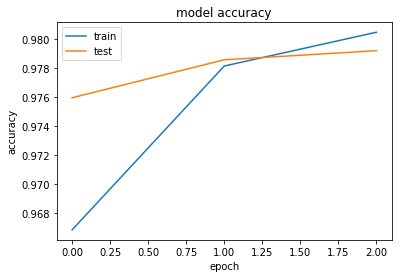

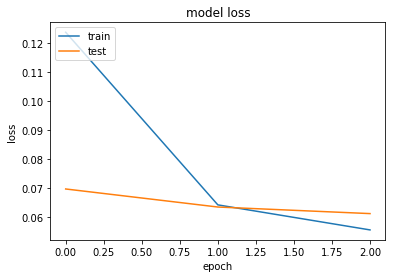

In [36]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
roc_auc_score(yTest, lstmModel.predict(xTest))

0.95871187823232873